In [132]:
import pandas as pd
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, accuracy_score

import os
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

here = os.getcwd()
main = here.split("\\")
home = "\\".join(main[:-2])
home

'c:\\Users\\Tan Duong\\OneDrive - vnu.edu.vn\\UET\\MEMS\\CountCell\\featuresBasedForCountCellSig'

In [134]:
def cutThresh(df, feature_ranges):
    """
    Filter a DataFrame to keep only the samples where all features fall within specified ranges.

    Parameters:
        df (DataFrame): Input DataFrame.
        feature_ranges (dict): Dictionary specifying the range for each feature.
                               Keys are column names, values are tuples (min_val, max_val).

    Returns:
        DataFrame: Filtered DataFrame.
    """
    for feature, (min_val, max_val) in feature_ranges.items():
        df = df[(df[feature] >= min_val) & (df[feature] <= max_val)]
    return df

# draw distribution
def IQR_show(data):
    # Example DataFrame with 9 features

    # Calculate the IQR for each feature
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Create subplots
    fig, axs = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle('Box Plots of Each Feature')

    # Plot each feature in a separate subplot
    features = data.columns
    for i, ax in enumerate(axs.flatten()):
        ax.boxplot(data[features[i]])
        ax.set_title(features[i])

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
    plt.show()

In [151]:
# Load the dataset
data_positive = pd.read_csv(os.path.join(home,'truePositive.csv'))
data_negative = pd.read_csv(os.path.join(home,'falsePositive.csv'))

X = pd.concat([data_positive,data_negative])
y = np.array([1]*len(data_positive) + [0] * len(data_negative))
columns = X.columns

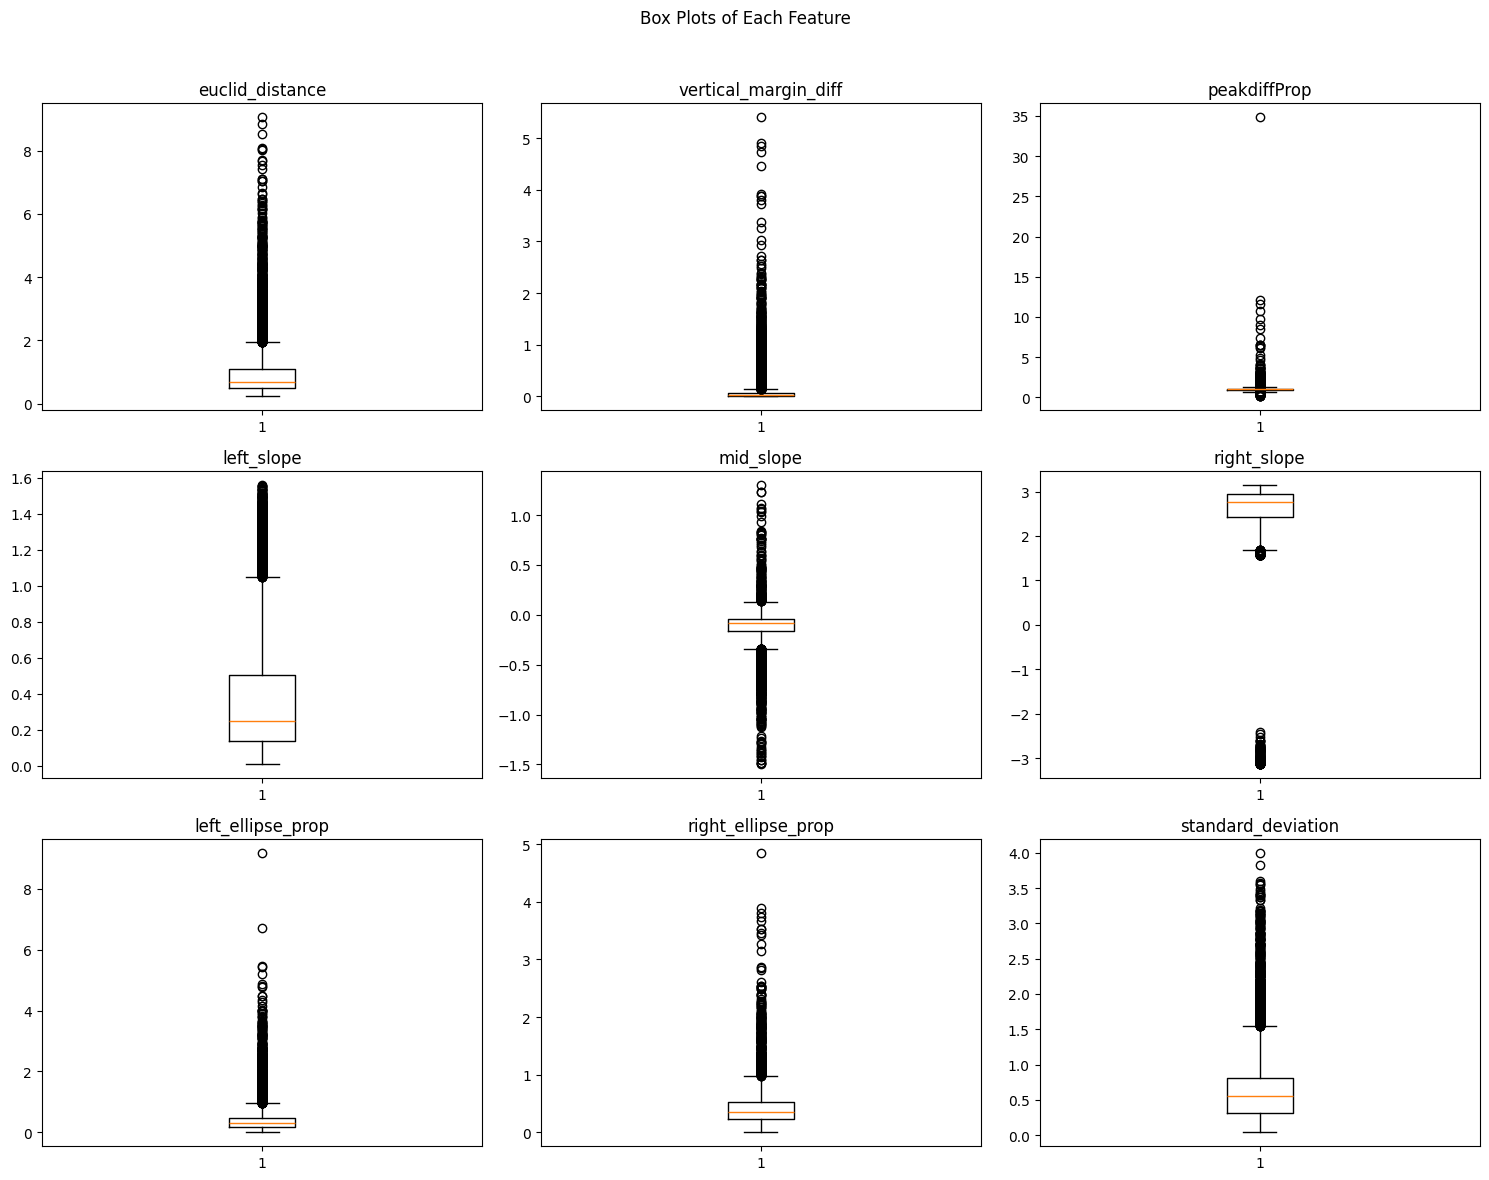

In [137]:
IQR_show(X)

## 1, Discard Outlier


In [152]:
# Step 1: Detect and Remove Outliers using IsolationForest
iso = IsolationForest(contamination=0.1, random_state=15)
yhat = iso.fit_predict(X)
mask = yhat != -1
X, y = X[mask], y[mask]
len(X)

10342

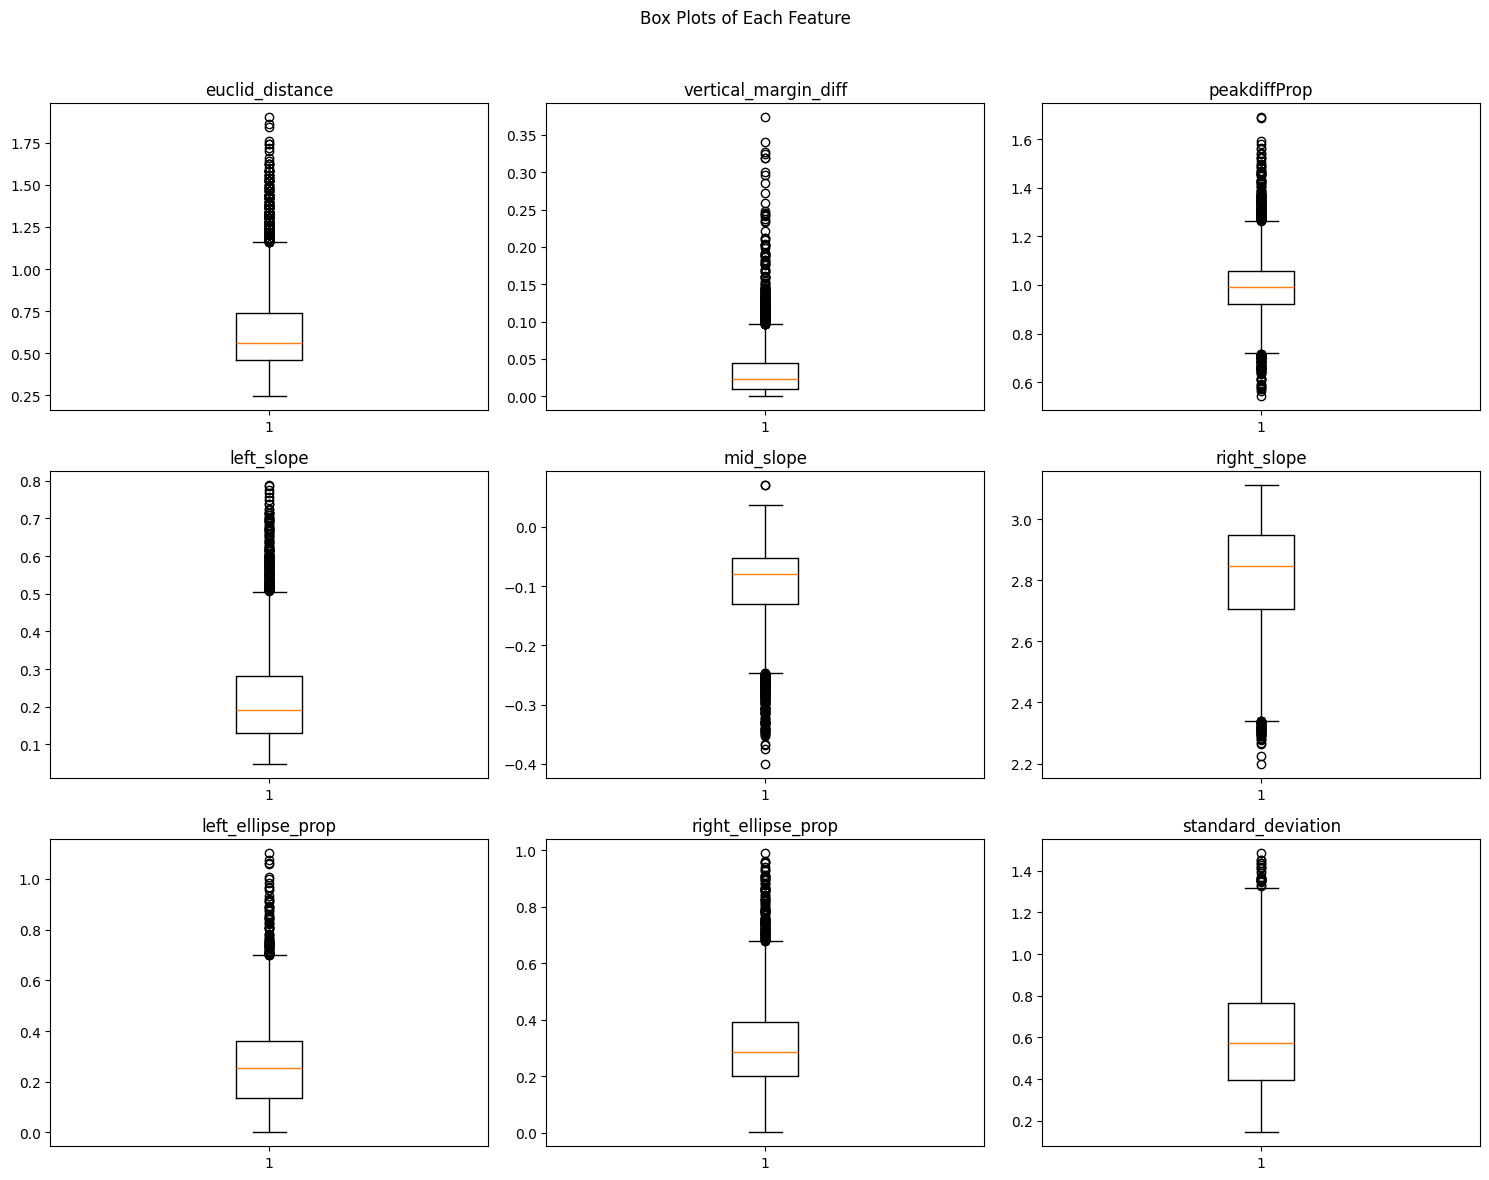

In [141]:
IQR_show(pd.DataFrame(X,columns=columns))

### Show distribution

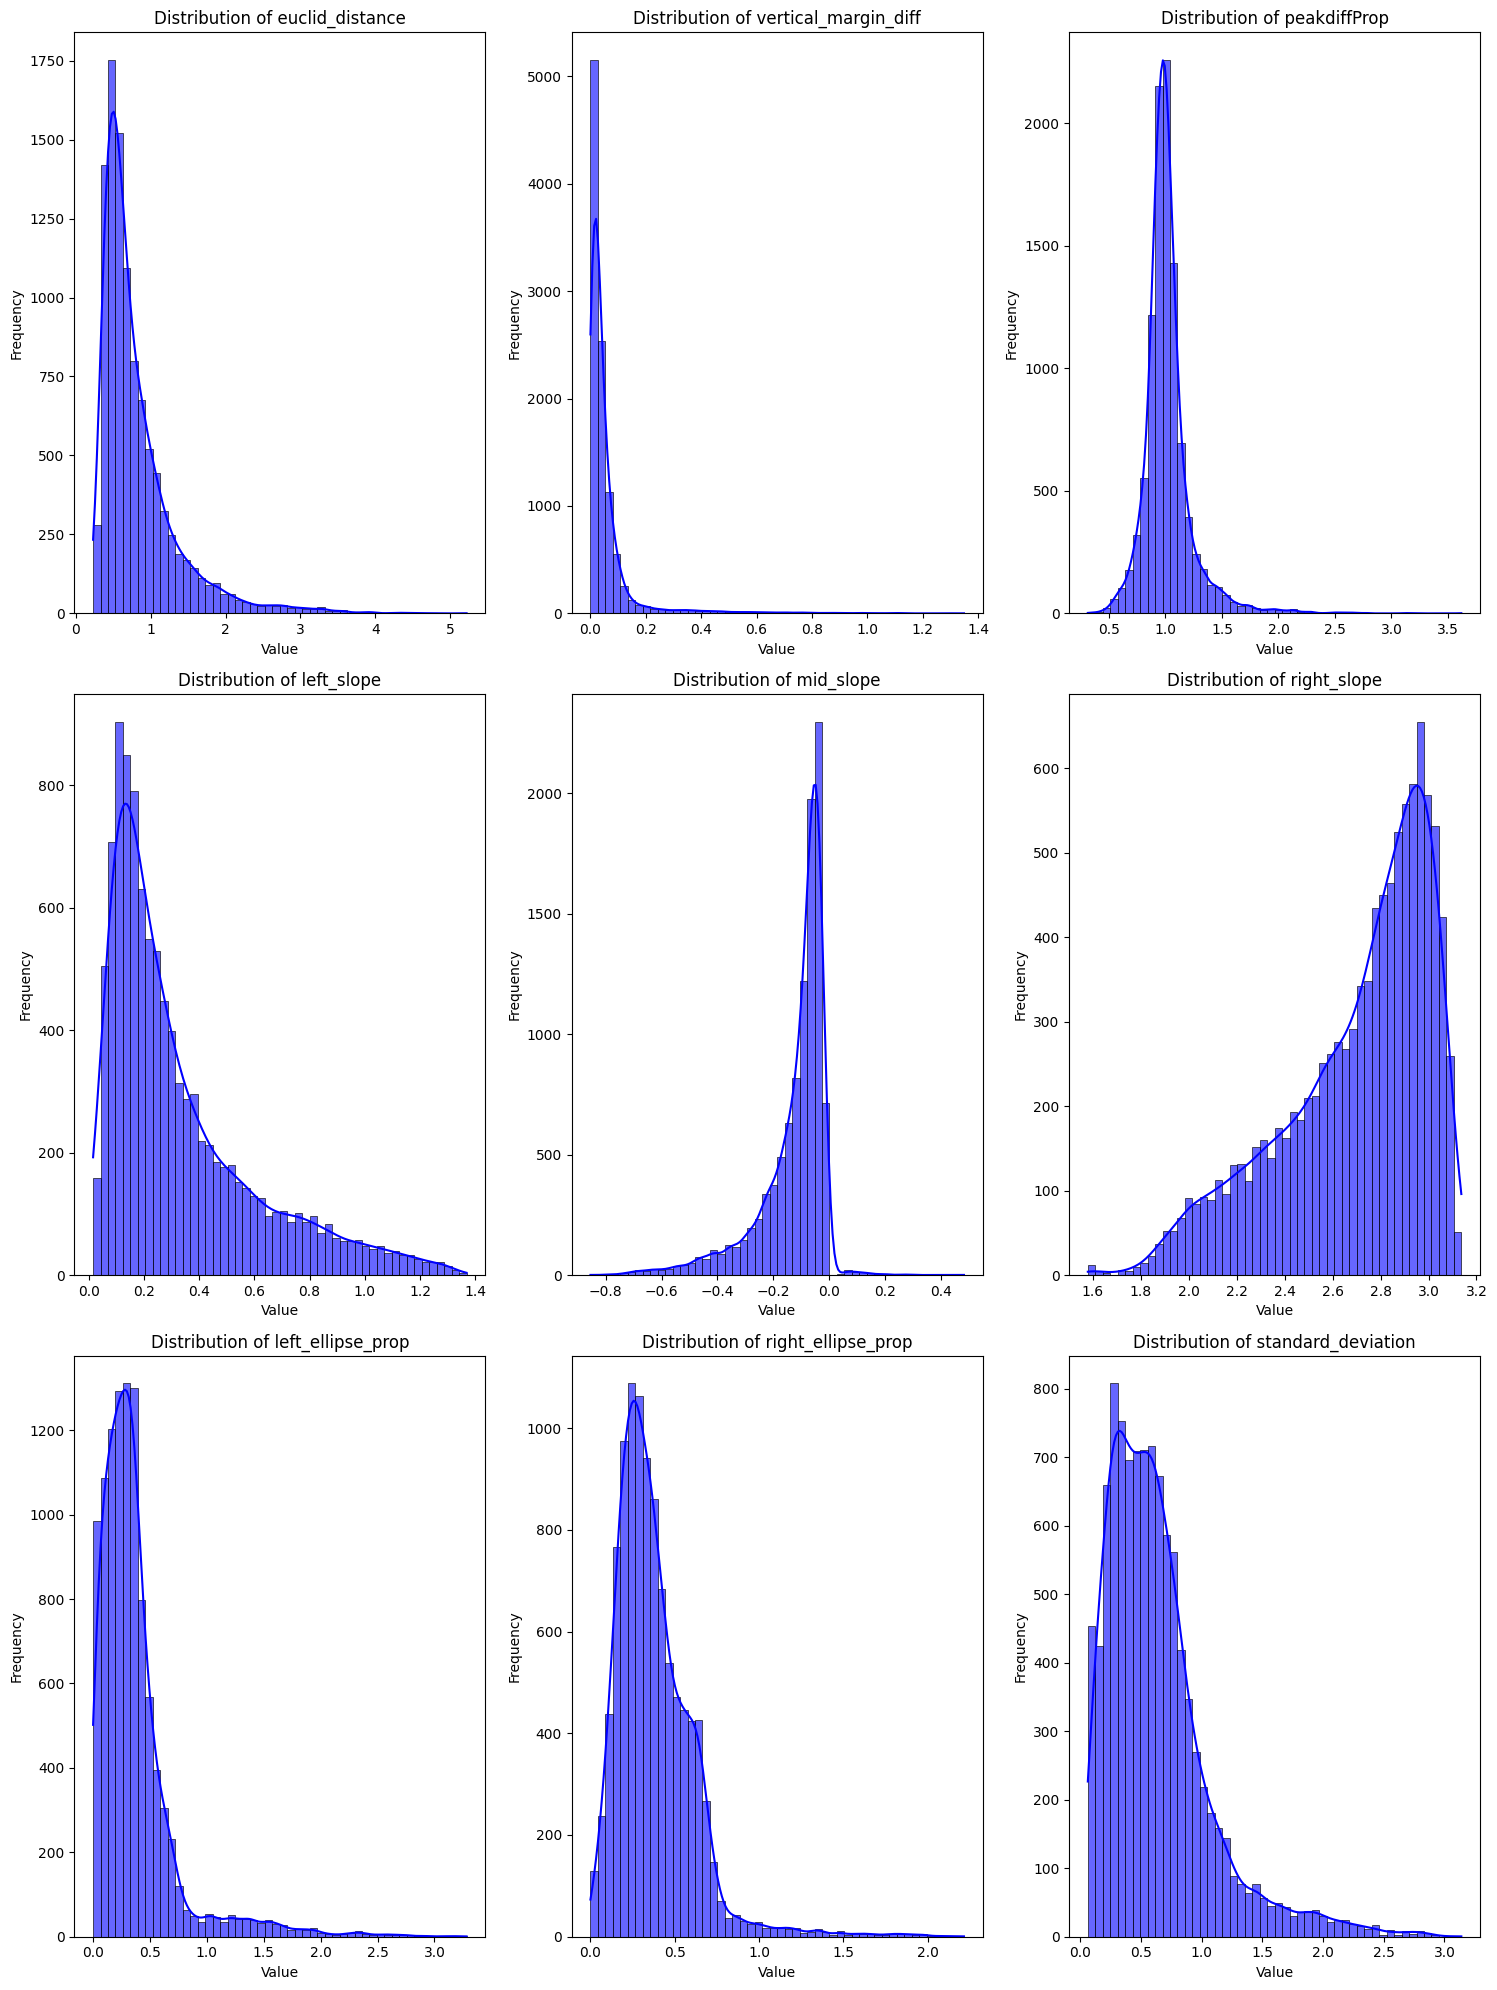

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fields= columns
dist_X = pd.DataFrame(X, columns=fields)

# Plotting the distribution
fig, axes = plt.subplots(3,3, figsize=(15, 20))
axes = axes.flatten()
# lim_x = [(0,8.0),(0,2.0),(0,5.0),(0,1.6),(-1.5,1),(-3,3.5),(0,4),(0,3),(0,3.5)]

for i, col in enumerate(fields):
    sns.histplot(dist_X[col], bins=50, kde=True, ax=axes[i], color='blue', alpha=0.6)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    # axes[i].set_xlim(lim_x[i])

plt.tight_layout()
plt.show()

In [144]:
columns

Index(['euclid_distance', 'vertical_margin_diff', 'peakdiffProp', 'left_slope',
       'mid_slope', 'right_slope', 'left_ellipse_prop', 'right_ellipse_prop',
       'standard_deviation'],
      dtype='object')

In [156]:
X_drop = X.drop(columns = ['vertical_margin_diff', 'peakdiffProp',
       'mid_slope'])

In [157]:
# X = pd.DataFrame(X, columns=columns)
# Step 2: Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_drop.columns)
    ])

# Step 3: Define the classifier
classifier = RandomForestClassifier(random_state=42)

# Step 4: Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Step 5: Define the scoring metric
scoring = make_scorer(accuracy_score)

# Step 6: Apply cross-validation
scores = cross_val_score(pipeline, X_drop, y, cv=8, scoring=scoring)

# Print the cross-validation scores
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")
print(f"Standard deviation of cross-validation score: {scores.std()}")


Cross-validation scores: [0.84686775 0.88012374 0.8716164  0.87470998 0.90177881 0.86929621
 0.84365325 0.74303406]
Mean cross-validation score: 0.8538850239082079
Standard deviation of cross-validation score: 0.04529036651856995


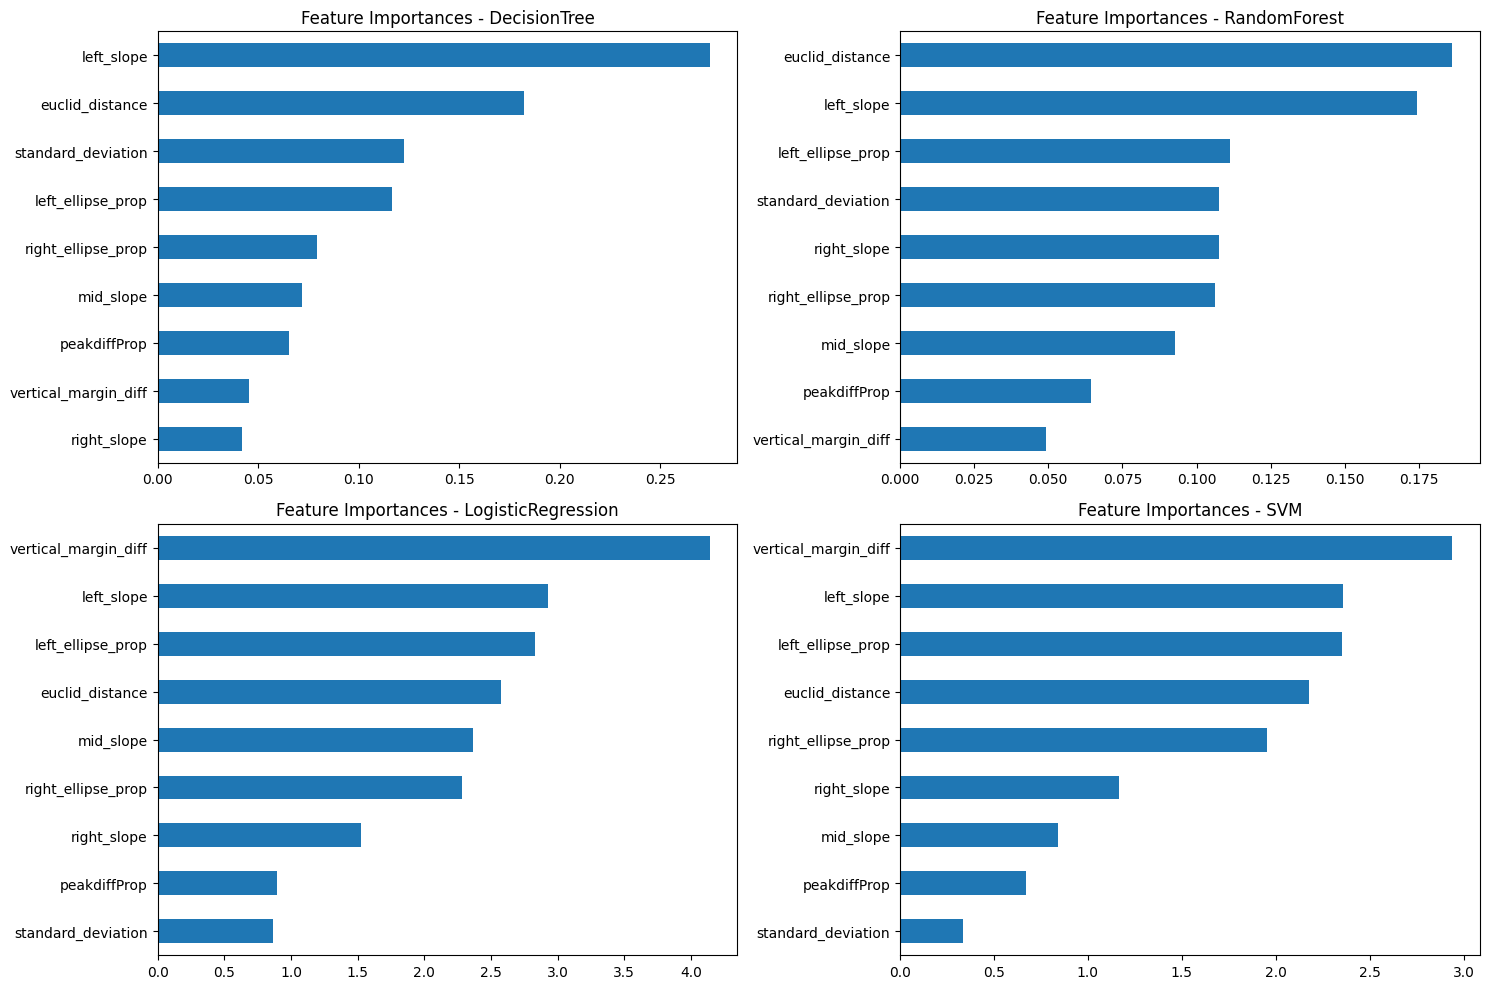

In [155]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Assuming your DataFrame 'df' has features and a 'Label' column

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the models
models = {
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear')
}

feature_importances = {}

# Train the models and get feature importances or coefficients
for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    if model_name in ['RandomForest', 'DecisionTree']:
        importances = model.feature_importances_
    elif model_name == 'LogisticRegression':
        importances = np.abs(model.coef_[0])
    elif model_name == 'SVM':
        importances = np.abs(model.coef_[0])
    
    feature_importances[model_name] = importances

# Convert feature importances to DataFrame for better visualization
importance_df = pd.DataFrame(feature_importances, index=X.columns)

# Plot the feature importances for each model
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for ax, model_name in zip(axes.flatten(), models.keys()):
    importance_df[model_name].sort_values().plot(kind='barh', ax=ax, title=f'Feature Importances - {model_name}')

plt.tight_layout()
plt.show()